<a href="https://colab.research.google.com/github/AnandVP123/q1/blob/main/Assignment2_Part_A_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wandb

     |████████████████████████████████| 1.7 MB 26.8 MB/s 
     |████████████████████████████████| 181 kB 59.4 MB/s 
     |████████████████████████████████| 144 kB 72.8 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=b99cfc59225833b88b0300011815b972fa857ab0fb06e1aa28af3c4d4ba9236e
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [ ]:
# importing all libraries & Training


import numpy as np
import pandas as pd
import os
import keras
import tensorflow as tf
from tensorflow.keras import layers,models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from wandb.keras import WandbCallback
import matplotlib.pyplot as plt
import cv2
import wandb
import matplotlib.image as mpimg



In [ ]:
%%capture
!curl -SL https://storage.googleapis.com/wandb_datasets/nature_12K.zip > nature_12K.zip
!unzip nature_12K.zip

train_dir='inaturalist_12K/train/'
test_dir='inaturalist_12K/val/'
categories=['Amphibia','Animalia','Arachnida','Aves','Fungi','Insecta','Mammalia','Mollusca','Plantae','Reptilia']


#zip_path = "drive/MyDrive/nature_12K.zip"
#!cp "{zip_path}" .
#!unzip -q nature_12K.zip
#!rm nature_12K.zip

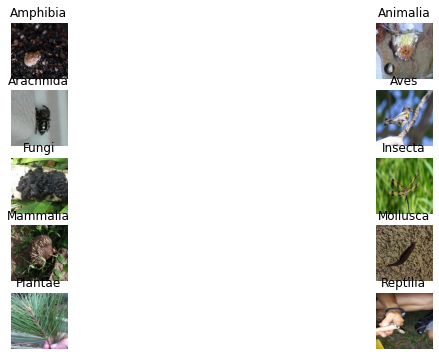

In [ ]:
#showing images in the iNaturalist dataset in rxc 5x2

j=1
fig = plt.figure(figsize=(12,6))
r,c =5,2

for category1 in categories:
  dir=os.path.join(train_dir,category1)
  for img in os.listdir(dir):
    img_path=(os.path.join(dir,img))
    imgs=mpimg.imread(img_path)
    new_img=cv2.resize(imgs,(300,300))
    fig.add_subplot(r,c,j)
    plt.imshow(new_img)
    plt.axis('off')
    plt.title(category1)
    j+=1   
    break

In [ ]:
#Using the sweep feature in wandb find the best hyperparameter configuration. Parameters are choosen based on the suggestion.

sweep_config = {'name': 'sweep7',  'method': 'grid','parameters': {
     #1. defining filters and their values all64, all32, 'increasing','dececreasing','increasing and decreasing','decreasing and increasing' (what is contained inside them is defined later)
                'filters': {'values': ['all_64','all_32','inc','dec','inc_dec','dec_inc'] },
     #2. filter con size: 128
                'fc_size':{'values':[128] },
     #3. Aug yes
                'augmentation':{'values':['yes'] },
     #4. Drop Rate of 40 and 50 percent
                'droprate':{'values':[0.4,0.5]},
     #5. Batch norm yes
        'batchnorm':{ 'values':['yes']} 
        } }
# default configuaration with 0.3 droprate & fc 256
cd={'filters':'inc','fc_size':256,'batchnorm':'yes','augmentation':'no','droprate':0.3}

In [ ]:
#idea adopted from https://towardsdatascience.com/convolutional-neural-networks-model-from-scratch-for-object-detection-820893610919
#https://pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/
#https://vijayabhaskar96.medium.com/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720

def Train_CNN():

  wandb.init(config=cd)
  cons=wandb.config
  cons=cd
  batchnorm=cons['batchnorm']
  droprate=cons['droprate']
  augmentation=cons['augmentation']
  filter_=cons['filters']
  fc_size=cons['fc_size']

  wandb.run.name='filters_'+filter_+'_fc_size_'+str(fc_size)+'_droprate_'+str(droprate)+ str('_bn_' if batchnorm=='yes' else '') +str('augment' if augmentation=='yes' else '')


#define all64,all32
  if filter_ == 'all_32':filters=[32,32,32,32,32]
  elif filter_=='all_64':filters=[64,64,64,64,64]
  elif filter_=='inc'   :filters=[16,32,64,128,256]
  elif filter_ =='dec'  :filters=[128,64,32,16,8]
  elif filter_ =='inc_dec' :filters=[32,64,128,64,32]
  elif filter_ =='dec_inc' :filters=[128,64,32,64,128]

  img_height,img_width=300,300
  model=models.Sequential()
#defining first cnn layer
  model.add(Conv2D(filters[0], (3, 3),input_shape=(img_height,img_width,3),activation='relu'))    
#normalise the i/ps 
  if batchnorm =='yes': model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))
#defining 2nd cnn layer
  model.add(Conv2D(filters[1], (3, 3),activation='relu'))
  model.add(MaxPooling2D((2, 2)))
#defining 3rd cnn layer
  model.add(Conv2D(filters[2], (3, 3),activation='relu'))
  model.add(MaxPooling2D((2, 2)))
#defining 4th cnn layer
  model.add(Conv2D(filters[3], (3, 3),activation='relu'))
  model.add(MaxPooling2D((2, 2)))
#defining 5th cnn layer
  model.add(Conv2D(filters[4], (3, 3),activation='relu'))
  if batchnorm =='yes':
    model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))

  model.add(Flatten())
  model.add(Dense(fc_size,activation='relu')) 
  if batchnorm =='yes':
    model.add(BatchNormalization())
  model.add(Dropout(droprate))
  model.add(Dense(10,activation='softmax'))
  #data generators for train(with and without augmentation) and validation set
  augment= ImageDataGenerator(rotation_range=30, width_shift_range=0.2, height_shift_range=0.2, zoom_range=0.2,horizontal_flip=True, rescale=1.0 / 255,validation_split=0.1,)
  datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.1,)

  train_set = datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    color_mode='rgb',
    class_mode='sparse',
    shuffle=True,
    subset='training',
    seed=123,
  )

  aug_set = augment.flow_from_directory(
      train_dir,
      target_size=(img_height, img_width),
      batch_size=32,
      color_mode='rgb',
      class_mode='sparse',
      shuffle=True,
      subset='training',
      seed=123,
  )

  val_set = datagen.flow_from_directory(
      train_dir,
      target_size=(img_height, img_width),
      color_mode='rgb',
      class_mode='sparse',
      shuffle=True,
      subset='validation',
      seed=123,
  )

  model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=[tf.keras.losses.SparseCategoricalCrossentropy()],
    metrics=['accuracy'],
  )

  if augmentation =='no' :
    #hist=model.fit(train_set,epochs=10,validation_data=val_set,callbacks=[WandbCallback()])
    hist=model.fit(train_set,epochs=10,validation_data=val_set,callbacks=[WandbCallback()])

  else:
    #hist=model.fit(aug_set,epochs=10,validation_data=val_set,callbacks=[WandbCallback()])
    hist=model.fit(aug_set,epochs=10,validation_data=val_set,callbacks=[WandbCallback()])
    callbacks=[WandbCallback(data_type="image", labels=categories)]
  
  val_acc=max(hist.history['val_accuracy'])
  params={'batch_norm':batchnorm,'augmentation':augmentation,'dropout':droprate,'filter_architecture':filter_,'val_accuracy':val_acc}
  wandb.log(params)
  

In [ ]:
#Training for default configuration
Train_CNN()


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Found 9000 images belonging to 10 classes.
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Epoch 1/10
282/282 [==============================] - 145s 476ms/step - loss: 2.3761 - accuracy: 0.2213 - val_loss: 3.0849 - val_accuracy: 0.1141 - _timestamp: 1648964841.0000 - _runtime: 155.0000
Epoch 2/10
282/282 [==============================] - 122s 431ms/step - loss: 2.1263 - accuracy: 0.2816 - val_loss: 2.0541 - val_accuracy: 0.2523 - _timestamp: 1648964962.0000 - _runtime: 276.0000
Epoch 3/10
282/282 [==============================] - 118s 418ms/step - loss: 2.0180 - accuracy: 0.2977 - val_loss: 2.1172 - val_accuracy: 0.2773 - _timestamp: 1648965080.0000 - _runtime: 394.0000
Epoch 4/10
282/282 [==============================] - 118s 417ms/step - loss: 1.9245 - accuracy: 0.3250 - val_loss: 2.0700 - val_accuracy: 0.2883 - _timestamp: 1648965198.0000 - _runtime: 512.0000
Epoch 5/10
282/282 [==============================] - 117s 415ms/step - loss: 1.8091

In [ ]:
#Sweeping for various strategy(different filter architecture)
sweep_id=wandb.sweep(sweep_config,entity='ee20d064oe21d019',project='uncategorized')
wandb.agent(sweep_id, Train_CNN)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: l2s4hd27
Sweep URL: https://wandb.ai/ee20d064oe21d019/uncategorized/sweeps/l2s4hd27


wandb: Agent Starting Run: 0jf0rqv4 with config:
wandb: 	augmentation: yes
wandb: 	batchnorm: yes
wandb: 	droprate: 0.4
wandb: 	fc_size: 128
wandb: 	filters: all_64


Found 9000 images belonging to 10 classes.
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Epoch 1/10
  5/282 [..............................] - ETA: 1:47 - loss: 3.9008 - accuracy: 0.1312

wandb: Ctrl + C detected. Stopping sweep.


In [ ]:
#Best configured Model Training
model=models.Sequential()
img_height,img_width=300,300
#Convolution layer 1
model.add(Conv2D(16,(3, 3),input_shape=(img_height,img_width,3),activation='relu'))    
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
#Convolution layer 21
model.add(Conv2D(32, (3, 3),activation='relu'))
model.add(MaxPooling2D((2, 2)))
#Convolution layer 3
model.add(Conv2D(64, (3, 3),activation='relu'))
model.add(MaxPooling2D((2, 2)))
#Convolution layer 4
model.add(Conv2D(128, (3, 3),activation='relu'))
model.add(MaxPooling2D((2, 2)))
#Convolution layer 5
model.add(Conv2D(256, (3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
#Flatten layer
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
#Dense layer
model.add(Dense(10,activation='softmax'))
#Displaying the summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 298, 298, 16)      448       
                                                                 
 batch_normalization_3 (Batc  (None, 298, 298, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 149, 149, 16)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                      

In [ ]:
#For Knowing layer names
layer_names = [layer.name for layer in model.layers]
layer_names

['conv2d_5',
 'batch_normalization_3',
 'max_pooling2d_5',
 'conv2d_6',
 'max_pooling2d_6',
 'conv2d_7',
 'max_pooling2d_7',
 'conv2d_8',
 'max_pooling2d_8',
 'conv2d_9',
 'batch_normalization_4',
 'max_pooling2d_9',
 'flatten_1',
 'dense_2',
 'batch_normalization_5',
 'dropout_1',
 'dense_3']

In [ ]:
#Train set & Validation set-Data Genarator
#For Augmentation
augment= ImageDataGenerator(rotation_range=30,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,rescale=1.0 / 255,validation_split=0.1)
#For Data Generation & Rescaling
datagen = ImageDataGenerator(rescale=1.0 / 255,validation_split=0.1)
#For Training Set
train_set = datagen.flow_from_directory(train_dir,target_size=(img_height, img_width),batch_size=32,color_mode='rgb',class_mode='sparse',shuffle=True,subset='training',seed=123,)
#For Augmentation set
aug_set = augment.flow_from_directory(train_dir,target_size=(img_height, img_width),batch_size=32,color_mode='rgb',class_mode='sparse',shuffle=True,subset='training',seed=123,)
#For Validation
val_set = datagen.flow_from_directory(train_dir,target_size=(img_height, img_width),color_mode='rgb',class_mode='sparse',shuffle=True,subset='validation',seed=123,)

Found 9000 images belonging to 10 classes.
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.


In [ ]:
#Compiling the model using keras optimizers 
model.compile(optimizer=tf.keras.optimizers.Adam(),loss=[tf.keras.losses.SparseCategoricalCrossentropy()],metrics=['accuracy'],)
#Including for early-stop
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3,restore_best_weights=True)
#Fitting the model
model.fit(train_set,epochs=10,validation_data=val_set,callbacks=[early_stop])

Epoch 1/10
282/282 [==============================] - 119s 418ms/step - loss: 2.3777 - accuracy: 0.2168 - val_loss: 2.3831 - val_accuracy: 0.1291
Epoch 2/10
282/282 [==============================] - 117s 415ms/step - loss: 2.1453 - accuracy: 0.2722 - val_loss: 2.1583 - val_accuracy: 0.2593
Epoch 3/10
282/282 [==============================] - 116s 412ms/step - loss: 2.0002 - accuracy: 0.3110 - val_loss: 2.5961 - val_accuracy: 0.2492
Epoch 4/10
282/282 [==============================] - 116s 411ms/step - loss: 1.9038 - accuracy: 0.3333 - val_loss: 2.0268 - val_accuracy: 0.3113
Epoch 5/10
282/282 [==============================] - 115s 409ms/step - loss: 1.8088 - accuracy: 0.3642 - val_loss: 2.0568 - val_accuracy: 0.2983
Epoch 6/10
282/282 [==============================] - 116s 411ms/step - loss: 1.7100 - accuracy: 0.3990 - val_loss: 1.9853 - val_accuracy: 0.3223
Epoch 7/10
282/282 [==============================] - 116s 410ms/step - loss: 1.6041 - accuracy: 0.4457 - val_loss: 2.0807 -

In [ ]:

#evaluating model on test set
#data generator for test set
test_datagen = ImageDataGenerator(rescale=1.0 / 255,)
test_set = test_datagen.flow_from_directory(test_dir,target_size=(img_height, img_width),color_mode='rgb',class_mode='sparse',shuffle=True,seed=123,)
model.evaluate(test_set)

Found 2000 images belonging to 10 classes.
63/63 [==============================] - 27s 427ms/step - loss: 1.9094 - accuracy: 0.3620


[1.9093619585037231, 0.3619999885559082]

wandb: Currently logged in as: ee20d064oe21d019 (use `wandb login --relogin` to force relogin)
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


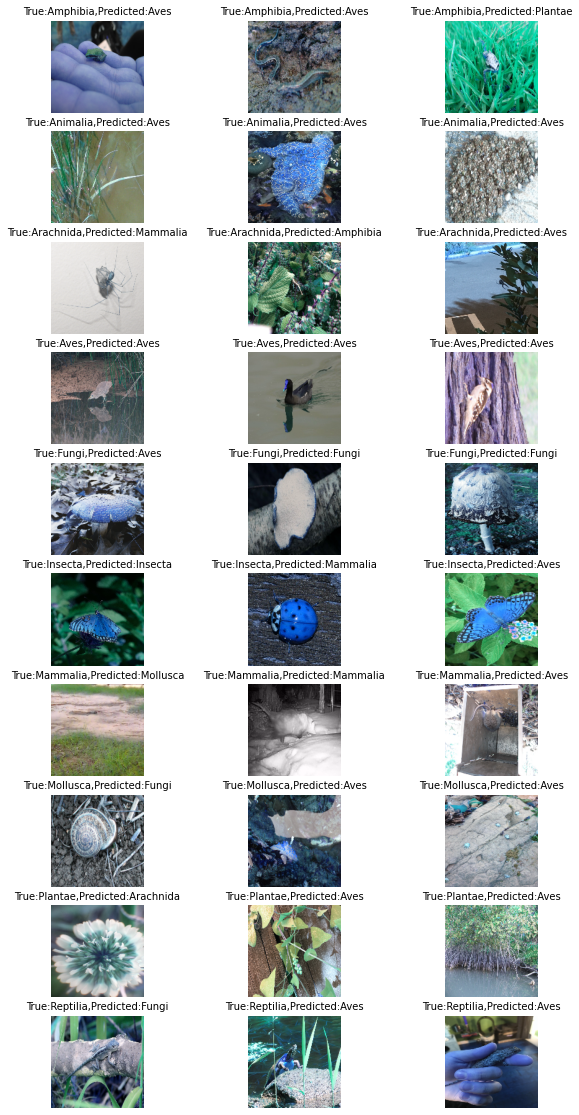

In [ ]:
x,y,prediction_y=[],[],[]
for category in categories:
    i=0
    path=os.path.join(test_dir,category)
    for img in os.listdir(path):
      if i==3:
        break
      try:
        image = cv2.imread(os.path.join(path,img),cv2.IMREAD_COLOR)
        x.append(image)
        y.append(category)
        pic = cv2.resize(image, (300,300)) / 255.0
        prediction = model.predict(pic.reshape(1,300, 300,3))
        c=prediction.argmax()
        prediction_y.append(categories[c])
        i+=1
      except:
        break
#plotting grids with true & predictions
fig = plt.figure(figsize=(10,20))
r,c=10,3
i=1
for k in range(30):
  img=cv2.resize(x[k],(150,150))
  fig.add_subplot(r,c,i)
  plt.imshow(img)
  plt.axis('off')
  plt.title('True:'+y[k]+',Predicted:'+prediction_y[k],fontdict={'fontsize':10})
  i+=1 
#Importing to wandb  
wandb.init(entity='ee20d064oe21d019',project='uncategorized')


In [ ]:
#Filter & Feature map visualization
#Defining the layer for filter
def fil_vis(layer_name='conv2d_5'):
fil_model = tf.keras.models.Model(inputs = [model.inputs],outputs = [model.get_layer(layer_name).output])
category = categories[0]
dir=os.path.join(test_dir,category)
for img in os.listdir(dir):
    img_path=(os.path.join(dir,img))
    imgs=cv2.imread(img_path)
    imgs=mpimg.imread(img_path)
    new_img=cv2.resize(imgs,(300,300))
    x = np.expand_dims(new_img, axis=0) 
    inputs = tf.cast(x, tf.float32)
    out = fil_model(inputs)[0]
    n_filters, ix = 16, 1
    plt.figure(figsize=(20,20))
    for i in range(n_filters):
      f = out[:, :, i]
      for j in range(3):
        ax = plt.subplot(4, 4, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(f)
      ix += 1
    plt.show()
    break


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


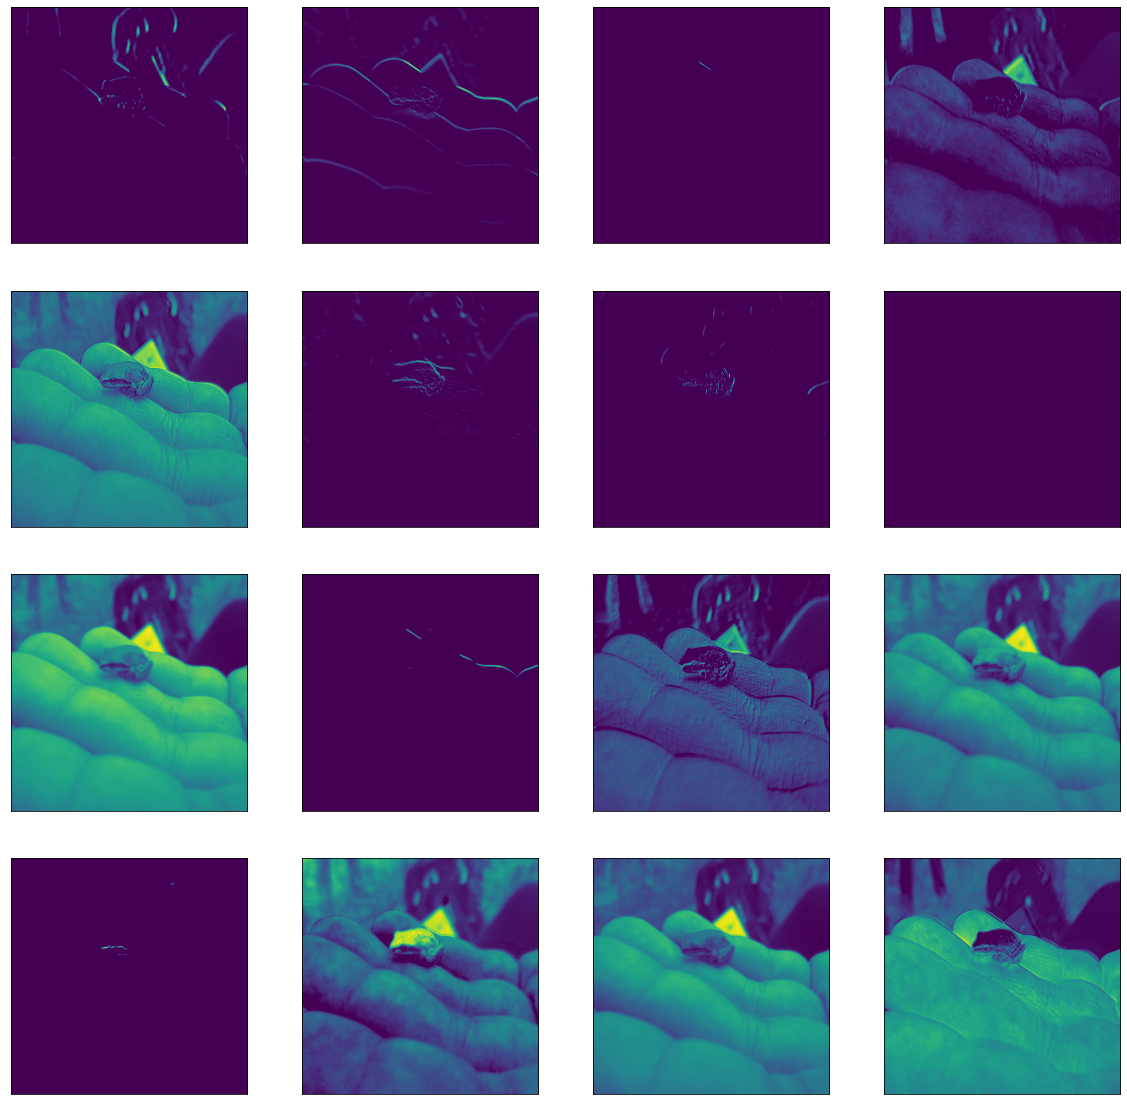

In [ ]:
#Displaying the output image for filter layers
fil_vis(layer_name='conv2d_5')

In [ ]:
#Guided Propagation
ln = 'conv2d_5'
@tf.custom_gradient
def guidedRelu(x):
  def grad(dy):
    return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
  return tf.nn.relu(x), grad

def guidedprop(model, layer=ln, N_neu=10, cat = 0,fil = 2):
  gb= tf.keras.models.Model(
    inputs = [model.inputs],    
    outputs = [model.get_layer(ln).output])
  ld = [layer for layer in gb.layers[1:] if hasattr(layer,'activation')]
  for layer in ld:
    if layer.activation == tf.keras.activations.relu:
      layer.activation = guidedRelu
  category = categories[cat]
  dir=os.path.join(train_dir,category)
  fig = plt.figure(figsize=(30,20))
  for img in os.listdir(dir):
    r= 2
    c=5
    img_path=(os.path.join(dir,img))
    imgs=cv2.imread(img_path)
    imgs=mpimg.imread(img_path)
    new_img=cv2.resize(imgs,(300,300))
    x = np.expand_dims(new_img, axis=0)
    i=0
    j = 1
    while j <= N_neu:
      with tf.GradientTape() as tape:
        inputs = tf.cast(x, tf.float32)
        tape.watch(inputs)
        outputs = gb(inputs)[0]
        if outputs[i,i,fil] != 0:
          out = outputs[i,i,fil]
          grads = tape.gradient(out,inputs)[0]
          guided_back_prop =grads
          viz_gb = np.dstack((guided_back_prop[:, :, 0],guided_back_prop[:, :, 1],guided_back_prop[:, :, 2],))       
          viz_gb -= np.min(viz_gb)
          viz_gb /= viz_gb.max()
          fig.add_subplot(r,c,j)
          plt.imshow(viz_gb)
          plt.title(category)
          j+=1
          i+=1
        else:
          i+=1  
    break

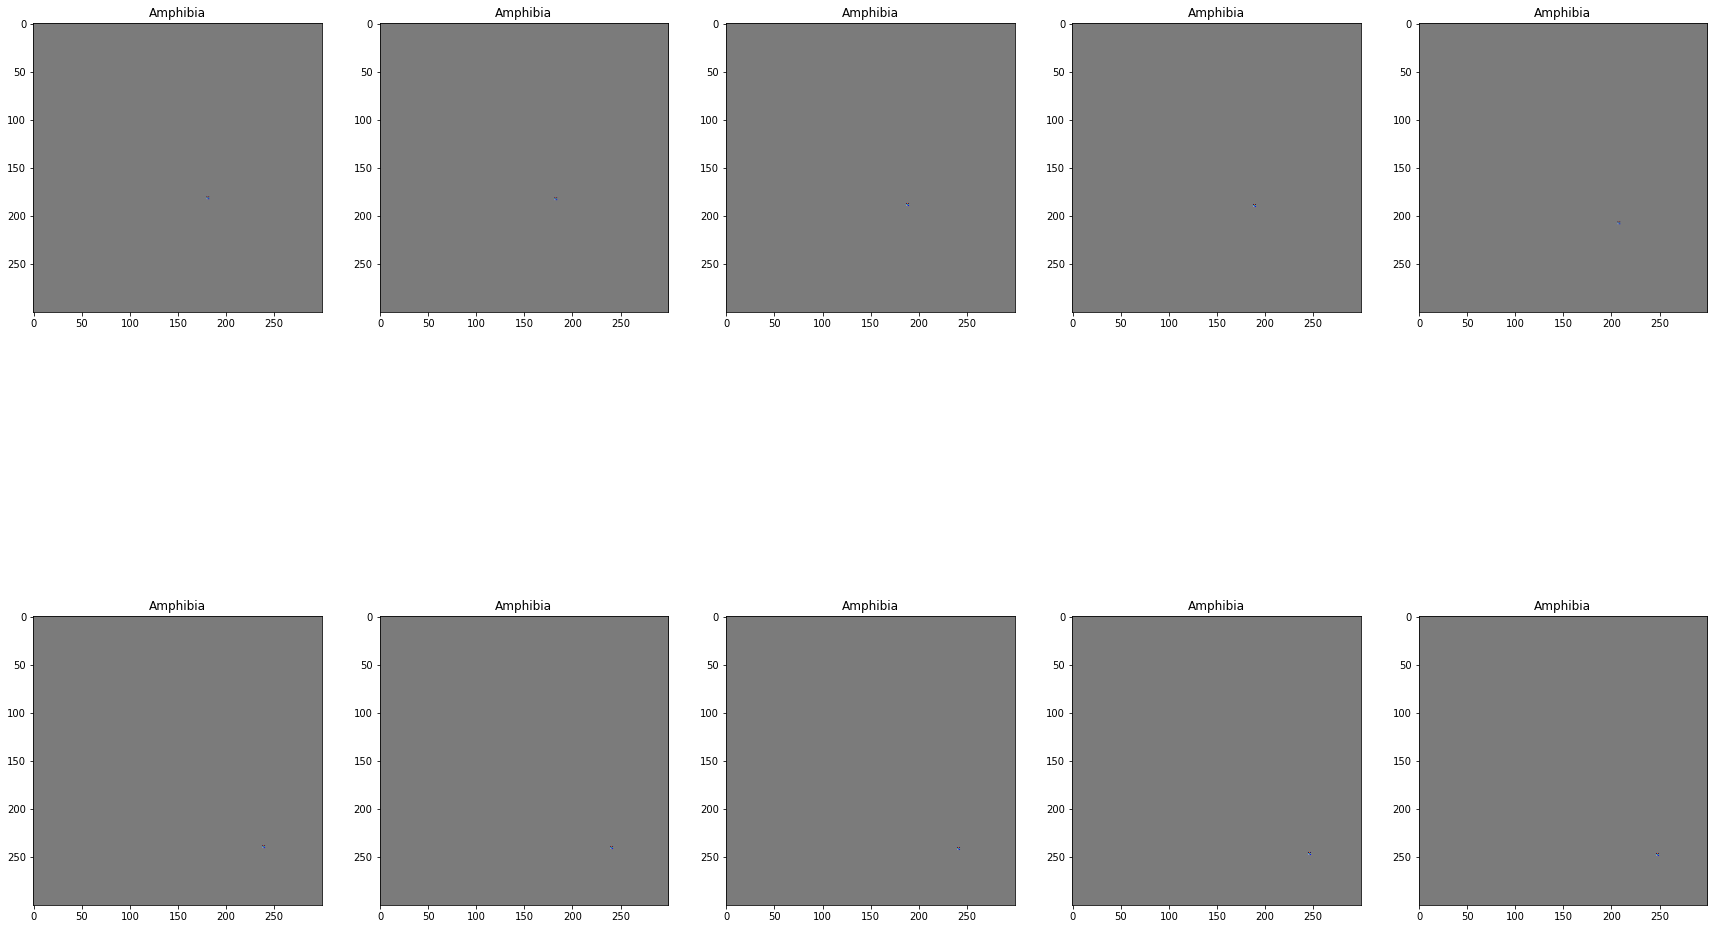

In [ ]:
guidedprop(model)